In [1]:
import os
import zipfile
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.meteor_score import meteor_score
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from rouge_score import rouge_scorer
from PIL import Image
import pickle
import glob
import time

In [2]:
IMAGE_DIR = r"C:\Users\srija\Desktop\flickr30k_images\flickr30k_images"
CAPTION_FILE = r"C:\Users\srija\Desktop\flickr30k_images\results.csv"

In [3]:
df = pd.read_csv(CAPTION_FILE, delimiter='|')
df.columns = ['image', 'comment_number', 'comment']
df = df[['image', 'comment']]

In [4]:
captions_dict = {}
for img, caption in zip(df['image'], df['comment']):
    if img not in captions_dict:
        captions_dict[img] = []
    captions_dict[img].append(caption)

In [5]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [6]:
FEATURES_FILE = 'features.pkl'  # In the same directory as your notebook
BATCH_SIZE = 32  # Set your desired batch size for feature extraction

# Helper function to preprocess and batch images
def preprocess_batch(image_paths):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(224, 224))  # VGG16 expects 224x224 input
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)  # Preprocess the image for VGG16
        images.append(img)
    return np.vstack(images)  # Return a batch of images

# Extract features from images using VGG16
def extract_features(directory):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)  # Get the penultimate layer
    features = {}
    image_paths = [os.path.join(directory, img_name) for img_name in os.listdir(directory)]
    
    # Process images in batches
    for i in tqdm(range(0, len(image_paths), BATCH_SIZE)):
        batch_paths = image_paths[i:i + BATCH_SIZE]
        batch_images = preprocess_batch(batch_paths)
        
        try:
            batch_features = model.predict(batch_images, verbose=0)
            for img_name, feature in zip(batch_paths, batch_features):
                features[os.path.basename(img_name)] = feature
        except Exception as e:
            print(f"Error processing batch {i}-{i+BATCH_SIZE}: {e}")
            continue
    return features

# Load or extract image features
if os.path.isfile(FEATURES_FILE):
    print("Loading existing image features from 'features.pkl'...")
    with open(FEATURES_FILE, 'rb') as f:
        features = pickle.load(f)
else:
    print("Extracting image features...")
    start = time.time()
    features = extract_features(IMAGE_DIR)
    with open(FEATURES_FILE, 'wb') as f:
        pickle.dump(features, f)
    print(f"Feature extraction completed in {(time.time() - start)/60:.2f} minutes")

Loading existing image features from 'features.pkl'...


In [7]:
from keras.preprocessing.text import Tokenizer

# Clean captions
def clean_captions(captions_dict):
    table = str.maketrans('', '', '"!@#$%^&*()-_=+{}[]|;:<>,.?/~`')
    cleaned = {}
    for img, captions in captions_dict.items():
        cleaned[img] = []
        for caption in captions:
            if not isinstance(caption, str):
                continue  # skip non-string captions
            caption = caption.lower().translate(table).strip()
            caption = "startseq " + caption + " endseq"
            cleaned[img].append(caption)
    return cleaned

# ✅ Make sure this line is run
cleaned_captions = clean_captions(captions_dict)

# Create vocabulary and tokenizer
all_captions = [cap for caps in cleaned_captions.values() for cap in caps]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Maximum length of a caption
max_length = max(len(caption.split()) for caption in all_captions)

print(f"Vocabulary Size: {vocab_size}")
print(f"Maximum Caption Length: {max_length}")

Vocabulary Size: 20031
Maximum Caption Length: 80


In [8]:
# Define the model
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Check if a saved model exists, if so load it
model_path = 'new_best_model.h5'

if os.path.exists(model_path):
    print("Loading existing model...")
    model = load_model(model_path)
    training_needed = False  # Model exists, so no need to train
else:
    print("No existing model found. Creating a new model...")
    model = define_model(vocab_size, max_length)
    model.summary()
    training_needed = True  # New model, so need to train

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size, batch_size=16):
    while True:
        keys = list(descriptions.keys())
        np.random.shuffle(keys)
        for i in range(0, len(keys), batch_size):
            X1, X2, y = [], [], []
            for key in keys[i:i+batch_size]:
                if key not in photos:
                    continue
                photo_vector = np.squeeze(photos[key])
                if photo_vector.shape[-1] != 4096:
                    continue
                desc_list = descriptions[key]
                for desc in desc_list:
                    seq = tokenizer.texts_to_sequences([desc])[0]
                    for j in range(1, len(seq)):
                        in_seq, out_seq = seq[:j], seq[j]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(photo_vector)
                        X2.append(in_seq)
                        y.append(out_seq)
            if X1:
                yield [np.array(X1), np.array(X2)], np.array(y)


# Only train if the model is newly created
if training_needed:
    steps = sum(len(c) for c in cleaned_captions.values())
    print(steps)
    steps = steps // 800
    print(steps)
    checkpoint = ModelCheckpoint(model_path, monitor='loss', save_best_only=True)
    generator = data_generator(cleaned_captions, features, tokenizer, max_length, vocab_size)
    model.fit(generator, epochs=10, steps_per_epoch=steps, verbose=2, callbacks=[checkpoint])

    model.save(model_path)  # Save after training
else:
    print("Skipping training, using the loaded model.")

Loading existing model...
Skipping training, using the loaded model.


In [9]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [10]:

def predict_caption(model, photo, tokenizer, max_length):
    # Ensure photo is in batch format (1, 4096)
    photo = np.expand_dims(photo, axis=0)  # Adding a batch dimension
    
    # Start with the 'startseq' token
    in_text = 'startseq'
    
    # Generate caption by predicting next word iteratively
    for _ in range(max_length):
        # Convert the text to a sequence of tokens
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to ensure it matches the model's expected input size
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict the next word
        yhat = model.predict([photo, sequence], verbose=0)
        
        # Find the word with the highest probability
        yhat = np.argmax(yhat)
        
        # Convert the token index back to a word
        word = tokenizer.index_word.get(yhat, '')
        
        # If the word is 'endseq', stop caption generation
        if word == 'endseq':
            break
        
        # Append the predicted word to the input text
        in_text += ' ' + word
    
    return in_text


In [11]:
# Evaluation on test set
keys = list(cleaned_captions.keys())
np.random.seed(42)
test = np.random.choice(keys, 100)

In [12]:
# Path to store results
results_path = "results.pkl"

# Check if the results already exist
if os.path.exists(results_path):
    print("Loading saved results...")
    with open(results_path, "rb") as f:
        actual, predicted = pickle.load(f)
else:
    print("Running evaluation and saving results...")
    actual, predicted = [], []
    for key in tqdm(test):
        captions = cleaned_captions[key]
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        actual.append([c.split() for c in captions])
        predicted.append(y_pred.split())
    
    # Save results for later use
    with open(results_path, "wb") as f:
        pickle.dump((actual, predicted), f)

Loading saved results...


In [13]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [14]:
print(max_length)
with open("max_length.pkl", "wb") as f:
    pickle.dump(max_length, f)

80


In [15]:
from nltk.translate.bleu_score import SmoothingFunction

# Create a smoothing function instance
smooth = SmoothingFunction().method4  # You can experiment with different methods

# BLEU with smoothing
bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth)
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)

In [16]:
# METEOR
meteor_total = 0
for act, pred in zip(actual, predicted):
    meteor_total += max(meteor_score([ref], pred) for ref in act)
meteor_avg = meteor_total / len(actual)

In [17]:
# ROUGE-L
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_total = 0
for act, pred in zip(actual, predicted):
    hyp = ' '.join(pred)
    scores = [scorer.score(' '.join(ref), hyp)['rougeL'].fmeasure for ref in act]
    rouge_total += max(scores)
rouge_avg = rouge_total / len(actual)

In [18]:
# Save all metrics
metrics = {"BLEU-1": bleu1, "BLEU-2": bleu2, "METEOR": meteor_avg, "ROUGE-L": rouge_avg}
with open("all_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

In [19]:
print("✅ All metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

✅ All metrics:
BLEU-1: 0.5930
BLEU-2: 0.4374
METEOR: 0.3940
ROUGE-L: 0.4593


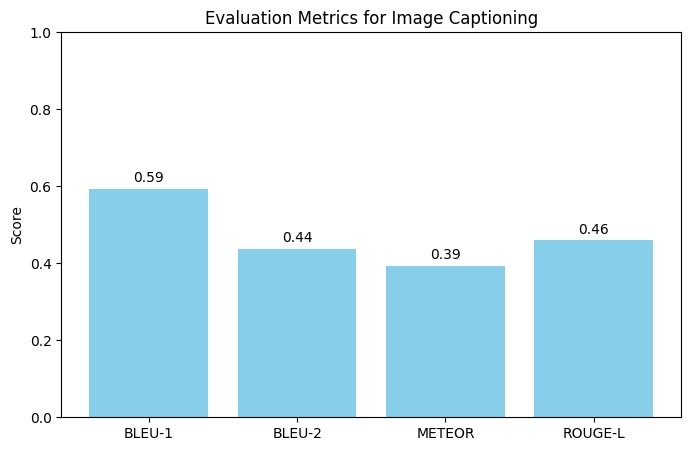

In [20]:
# Plot metrics
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Evaluation Metrics for Image Captioning")
plt.ylabel("Score")
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')
plt.show()

In [21]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def generate_caption(image_name):
    # 1) Normalize and strip whitespace
    image_name = os.path.basename(image_name.strip())

    # 2) Figure out which key we actually have in the dicts
    if   image_name in cleaned_captions:
        key = image_name
    else:
        no_ext = os.path.splitext(image_name)[0]
        if no_ext in cleaned_captions:
            key = no_ext
        else:
            # print a small sample of valid keys so you can see what's actually there
            sample_keys = list(cleaned_captions.keys())[:10]
            raise KeyError(
                f"Neither '{image_name}' nor '{no_ext}' found in cleaned_captions.\n"
                f"Here are 10 valid keys: {sample_keys}"
            )

    # 3) Grab captions & features
    actual_captions   = cleaned_captions[key]
    photo_vector      = features[key]
    predicted_caption = predict_caption(model, photo_vector, tokenizer, max_length)

    # 4) Show results
    print(f"\nImage key: {key}\n")
    print("---- Actual Captions ----")
    for c in actual_captions:
        print(" •", c)
    print("\n---- Predicted Caption ----")
    # drop the “startseq” token before printing
    print(" •", " ".join(predicted_caption.split()[1:]), "\n")

    # display the image
    img = Image.open(os.path.join(IMAGE_DIR, key if key.endswith('.jpg') else key + '.jpg'))
    plt.imshow(img)
    plt.axis('off')
    plt.show()




Image key: 36979.jpg

---- Actual Captions ----
 • startseq a group of friends playing cards and trying to bluff each other into making a terrible mistake endseq
 • startseq a group of college students gathers to play texas hold em poker endseq
 • startseq several men play cards while around a green table endseq
 • startseq a group of several men playing poker endseq
 • startseq six white males playing poker endseq

---- Predicted Caption ----
 • a group of people are playing video games 



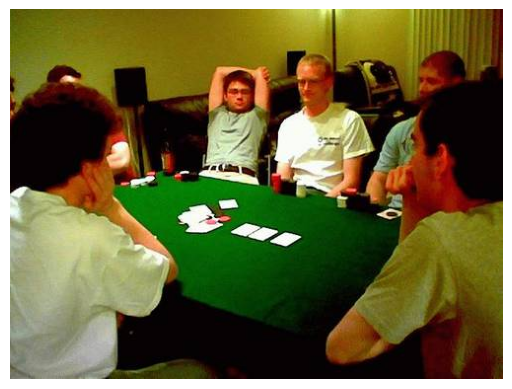


Image key: 10002456.jpg

---- Actual Captions ----
 • startseq several men in hard hats are operating a giant pulley system endseq
 • startseq workers look down from up above on a piece of equipment endseq
 • startseq two men working on a machine wearing hard hats endseq
 • startseq four men on top of a tall structure endseq
 • startseq three men on a large rig endseq

---- Predicted Caption ----
 • a man is working on a scaffold 



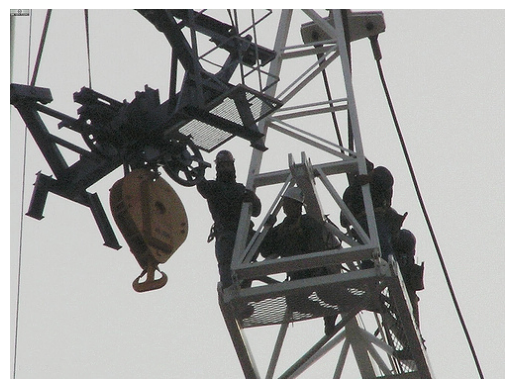

In [22]:
generate_caption("36979.jpg")
generate_caption("10002456.jpg")

In [25]:
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import io

# Upload widget for uploading one image
upload_widget = widgets.FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False     # Only single image
)

# Display the upload widget
display(upload_widget)

def extract_feature_single_image(image_path):
    from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.models import Model
    import numpy as np

    # Load VGG16 model
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Extract feature
    feature = model.predict(image, verbose=0)
    return feature

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    final_caption = in_text.split()[1:-1]  # remove startseq and endseq
    return ' '.join(final_caption)

def predict_caption(image_path, model, tokenizer, max_length):
    # Step 1: Extract features from the image
    photo = extract_feature_single_image(image_path)

    # Step 2: Generate the caption using your trained model
    caption = generate_desc(model, tokenizer, photo, max_length)

    return caption


FileUpload(value=(), accept='image/*', description='Upload')

In [24]:
upload_dir = "uploads"
if upload_widget.value:
    # Get uploaded file (supports both tuple or dict style)
    uploaded_file = list(upload_widget.value.values())[0] if isinstance(upload_widget.value, dict) else upload_widget.value[0]

    # Extract image data
    image_data = uploaded_file['content']
    image = Image.open(io.BytesIO(image_data)).convert('RGB')

    # Display the uploaded image
    display(image)

    # Generate a unique filename (e.g., using timestamp)
    filename = f"uploaded_{int(time.time())}.jpg"
    image_path = os.path.join(upload_dir, filename)
    
    # Save the image to the folder
    image.save(image_path)

    # Predict caption
    caption = predict_caption(image_path, model, tokenizer, max_length)
    print("\n📝Predicted Caption:", caption)
